# Coffee data - Natural Language Processing (NLP) mit spacy und wordcloud

## Load data and modules

In [1]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy import displacy
# englisch fast model
nlp = spacy.load("en_core_web_sm")

# english larger model
# nlp = spacy.load("en_core_web_trf")

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#additional stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [2]:
# Load prepared data

df = pd.read_pickle("coffee_data.pkl")

## Prepare Data

In [3]:
# Select columns with coffee notes
cols = ["submission_id"] + [
    col for col in df.columns
    if col.startswith("coffee_") and col.endswith("_notes")
]

notes = df[cols] 

# In long format
notes = notes.melt(
    id_vars="submission_id",
    var_name="variable",
    value_name="value"
)

# Adjust variable names
notes[['prefix', 'coffee', 'attribute']] = notes['variable'].str.extract(r'(coffee)_([a-zA-Z]+)_(\w+)')
notes = notes[notes['prefix'].notna()]

# Pivot to tidy long format
notes = notes.pivot_table(
    index=['submission_id', 'coffee'],
    columns='attribute',
    values='value',
    aggfunc='first',
    observed=False
).reset_index()

notes.columns.name = None  # Spaltenname bei Index entfernen
notes.head()

,submission_id,coffee,notes
0,0E11K6,a,Smooth
1,0E11K6,d,Flavor not to our liking. Very acidic
2,0E1D5Z,a,"Juicy, fruity"
3,0E1D5Z,b,"Chocolate, nutty"
4,0E1D5Z,d,Sweet


## Sprachanalyse

Word types are not always correctly identified with the simple model (e.g., "fruity" = noun). When only adjectives and adverbs are extracted, 
descriptions like "berry"/"apple" etc. are not included -> take nouns/proper nouns as well and include "wrong" ones later with stop list. 

In [28]:
nlp_acc = spacy.load("en_core_web_trf")
def analyze_acc(notes):
    # Deaktiviert Parsing, um die Verarbeitung zu beschleunigen
    with nlp_acc.disable_pipes("parser"):
        document = nlp_acc(notes)
        token = [w.text for w in document]
        lemma = [w.lemma_ for w in document]
        pos = [w.pos_ for w in document],
        # extract preprocessed adjectives and adverbs
        words = [w.lemma_.lower() for w in document if not w.is_stop and 
                                                    not w.is_punct and 
                                                    not w.is_space and
                                                    (w.pos_ == "ADJ" or
                                                    w.pos_ == "ADV" or
                                                    w.pos_ == "PROPN" or
                                                    w.pos_ == "NOUN")]
        return (token, lemma, pos, words)

# Wendet die Analyse auf die Spalte "notes" an und speichert die Ergebnisse in der neuen Spalte "analysis"
notes["analysis"] = notes["notes"].map(analyze_acc)

In [29]:
# Extrahiert Token, Lemma und POS aus der "analysis"-Spalte in separate Spalten
notes["tokens"] = notes["analysis"].apply(lambda x: x[0])
notes["lemmata"] = notes["analysis"].apply(lambda x: x[1])
notes["pos"] = notes["analysis"].apply(lambda x: x[2])
notes["words"] = notes["analysis"].apply(lambda x: x[3])
notes

,submission_id,coffee,notes,analysis,tokens,lemmata,pos,words
0,0E11K6,a,Smooth,"([Smooth], [smooth], ([ADJ],), [smooth])",[Smooth],[smooth],"([ADJ],)",[smooth]
1,0E11K6,d,Flavor not to our liking. Very acidic,"([Flavor, not, to, our, liking, ., Very, acidi...","[Flavor, not, to, our, liking, ., Very, acidic]","[flavor, not, to, our, liking, ., very, acidic]","([NOUN, PART, ADP, PRON, NOUN, PUNCT, ADV, ADJ],)","[liking, acidic]"
2,0E1D5Z,a,"Juicy, fruity","([Juicy, ,, fruity], [juicy, ,, fruity], ([ADJ...","[Juicy, ,, fruity]","[juicy, ,, fruity]","([ADJ, PUNCT, ADJ],)","[juicy, fruity]"
3,0E1D5Z,b,"Chocolate, nutty","([Chocolate, ,, nutty], [chocolate, ,, nutty],...","[Chocolate, ,, nutty]","[chocolate, ,, nutty]","([NOUN, PUNCT, ADJ],)","[chocolate, nutty]"
4,0E1D5Z,d,Sweet,"([Sweet], [sweet], ([ADJ],), [sweet])",[Sweet],[sweet],"([ADJ],)",[sweet]
...,...,...,...,...,...,...,...,...
9997,zKWy91,d,"Fruity, bright","([Fruity, ,, bright], [fruity, ,, bright], ([A...","[Fruity, ,, bright]","[fruity, ,, bright]","([ADJ, PUNCT, ADJ],)","[fruity, bright]"
9998,zKdykZ,a,"sour, round, funky","([sour, ,, round, ,, funky], [sour, ,, round, ...","[sour, ,, round, ,, funky]","[sour, ,, round, ,, funky]","([ADJ, PUNCT, ADJ, PUNCT, ADJ],)","[sour, round, funky]"
9999,zKdykZ,b,"woody, earthy","([woody, ,, earthy], [woody, ,, earthy], ([ADJ...","[woody, ,, earthy]","[woody, ,, earthy]","([ADJ, PUNCT, ADJ],)","[woody, earthy]"
10000,zKdykZ,c,clean,"([clean], [clean], ([ADJ],), [clean])",[clean],[clean],"([ADJ],)",[clean]


## Wordcloud

In [35]:
# Stop-Wort Liste erweitern

new_stopwords = {"little", "maybe", "mouth", "mouthfeel", "finish", "bodied", "hint", "definitely", "texture", "slightly"}
STOP_WORDS.update(new_stopwords)


[('fruity', 326), ('caramel', 257), ('light', 245), ('apple', 236), ('sweet', 198), ('bright', 186), ('citrus', 176), ('fruit', 173), ('sour', 149), ('lemon', 133), ('acidic', 126), ('berry', 102), ('chocolate', 96), ('acidity', 91), ('nutty', 88), ('balanced', 76), ('smooth', 75), ('juicy', 72), ('cherry', 71), ('honey', 59), ('floral', 59), ('acid', 52), ('orange', 51), ('tart', 48), ('good', 46), ('green apple', 45), ('raspberry', 44), ('bitter', 41), ('nice', 37), ('pear', 37)]
[('fruity', 440), ('blueberry', 280), ('fruit', 239), ('berry', 237), ('sour', 177), ('sweet', 156), ('cherry', 146), ('bright', 106), ('raspberry', 105), ('floral', 101), ('light', 100), ('juicy', 99), ('citrus', 98), ('funky', 97), ('apple', 95), ('chocolate', 94), ('acidic', 84), ('blackberry', 79), ('strawberry', 76), ('fermented', 68), ('lemon', 67), ('complex', 61), ('grape', 57), ('interesting', 52), ('acidity', 52), ('natural', 51), ('favorite', 51), ('fruity berry', 48), ('tart', 43), ('dark chocola

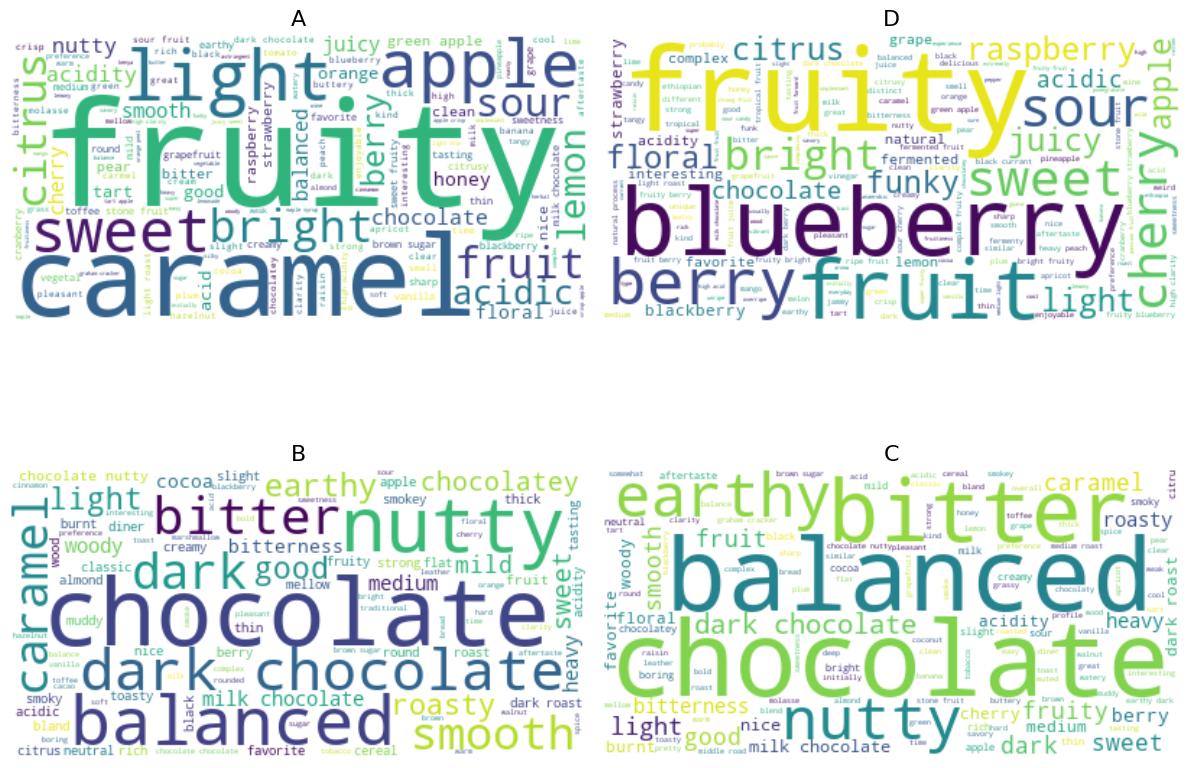

In [36]:
# plot für alle zusammen
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, cof in enumerate(notes["coffee"].unique()):
    # WordCloud needs one string of text to generate the wordcloud image, 
    # so we will filter and combine the text of one coffee
    #filter the df to one coffee, and create a list of responses from them
    text = notes[notes["coffee"]==cof]["words"].tolist() 
    from itertools import chain
    text = list(chain(*text))
    
    # join the list and lowercase all the words
    text = ' '.join(text).lower()

    #create the wordcloud object
    wordcloud = WordCloud(background_color='white',
                          stopwords=STOP_WORDS,
                          collocations=True, # zusammengesetzte Begriffe, default ist True
                          collocation_threshold=10, # wie häufig ein Wortpaar gemeinsam vorkommen muss, um als Collocation zu gelten
                          min_word_length=4 # Mindestanzahl Zeichen in einem Wort
                          ).generate(text) 

    axes[i].imshow(wordcloud, interpolation='bilInear')
    axes[i].set_title(cof.upper(), fontsize=16)
    axes[i].axis('off')

    # absolute word frequencies
    word_freq={k: v for k, v in sorted(wordcloud.process_text(text).items(),reverse=True, key=lambda item: item[1])}
    print(list(word_freq.items())[:30])

plt.tight_layout()
plt.show()

In [41]:
# einzelne plots speichern

for i, cof in enumerate(notes["coffee"].unique()):
    # WordCloud needs one string of text to generate the wordcloud image, 
    # so we will filter and combine the text of one coffee
    #filter the df to one coffee, and create a list of responses from them
    text = notes[notes["coffee"]==cof]["words"].tolist() 
    from itertools import chain
    text = list(chain(*text))
    
    # join the list and lowercase all the words
    text = ' '.join(text).lower()

    #create the wordcloud object
    wordcloud = WordCloud(width=2000, height=1200,
                          background_color='white',
                          stopwords=STOP_WORDS,
                          collocations=True, # zusammengesetzte Begriffe, default ist True
                          collocation_threshold=10, # wie häufig ein Wortpaar gemeinsam vorkommen muss, um als Collocation zu gelten
                          min_word_length=4 # Mindestanzahl Zeichen in einem Wort
                          ).generate(text) 
    plt.figure(figsize=(8,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    #plt.set_title(cof.upper(), fontsize=16)
    plt.axis('off')

    plt.savefig(f"assets/Coffee {cof.upper()}_wordcloud.png", dpi=300, bbox_inches='tight')
    plt.close()
